In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#from metrics import precision_at_k, recall_at_k

In [2]:
pip install metrics

Note: you may need to restart the kernel to use updated packages.


In [3]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [4]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [5]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [6]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [7]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [8]:
data_train.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [9]:
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\Users\tolpe\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
user_item_matrix

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [12]:
userid_to_id[1984]

1983

# ALS

In [13]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


Wall time: 3.43 s


In [14]:
[id_to_itemid[rec[0]] for rec in recs]

[1133018, 1106523, 999999, 1082185, 5569230]

In [15]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [16]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

NameError: name 'precision_at_k' is not defined

In [17]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 979707, 986912, 1051211, 995242]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 929668, 5568378, 1133018, 910032]"


### Embeddings

In [18]:
model.item_factors.shape

(5001, 100)

In [19]:
pd.DataFrame(model.item_factors)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.002694,0.002077,0.001771,0.001913,0.001901,0.003274,0.003097,0.004244,0.003739,0.001880,...,0.004549,0.002510,0.001760,0.003456,0.000847,0.001389,0.002739,0.003162,0.002735,0.004575
1,0.009087,-0.000252,0.002749,0.002786,-0.000586,0.001662,0.003233,0.003177,0.001558,-0.000994,...,0.001894,0.001902,-0.004147,0.005166,0.003007,0.000739,0.008632,0.001426,0.003223,0.000152
2,0.003984,0.001920,0.001073,0.004498,0.001629,0.003965,0.002148,0.002431,0.002961,0.002532,...,0.003558,0.002799,0.001818,0.002540,0.000227,0.001739,0.003103,0.003378,0.001851,0.000112
3,0.004651,0.001602,0.001867,0.001159,0.002795,0.002100,0.003219,0.002278,0.004123,0.000578,...,0.004353,0.002584,0.001370,0.003255,0.001196,0.002275,0.002806,0.003148,0.001906,0.003297
4,0.002453,0.001279,0.001511,0.001437,0.001878,0.002961,0.002121,0.002810,0.002734,0.001934,...,0.002962,0.001744,0.001633,0.002434,0.000698,0.001446,0.001718,0.002115,0.001485,0.003130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0.012227,0.012995,0.005146,0.008253,0.003269,0.004770,0.012973,0.003666,0.007123,0.004163,...,0.008126,-0.004552,0.003836,0.006296,0.004994,-0.002245,0.004881,0.003762,0.003597,-0.004448
4997,-0.001137,0.005736,-0.000602,0.002834,0.007832,0.001249,0.003665,0.007763,0.006349,0.000564,...,0.004086,0.003284,0.003013,0.002603,0.002409,0.008236,0.002007,0.004677,0.002911,0.007132
4998,0.004982,-0.000410,0.005829,0.003861,0.006239,0.004964,0.000550,0.005243,0.003218,0.003379,...,0.007198,0.003356,0.002129,0.001652,0.004801,0.006598,-0.001418,0.008450,0.001124,0.004129
4999,0.005200,0.000500,0.002749,0.000113,0.005518,0.004157,0.002076,0.007471,0.003897,-0.002560,...,0.006355,0.005028,0.001160,0.001142,0.002870,0.008518,0.004395,0.003543,0.006756,0.006238


In [20]:
model.user_factors.shape

(2499, 100)

In [21]:
pd.DataFrame(model.user_factors)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.560299,-7.969364,-3.780853,4.801449,-1.059314,-5.823499,-5.488094,-2.179257,7.283303,-3.914946,...,-3.811225,1.677985,4.091982,1.796574,1.524425,8.194096,-1.701606,4.424602,0.769357,-4.287794
1,1.829566,-1.567304,-3.623669,2.270527,-1.919021,-4.232003,-6.541227,-6.155891,8.454507,1.524079,...,-2.198394,1.761375,1.414332,-2.003635,2.049418,5.236231,2.241429,-1.381832,3.373032,-4.168690
2,1.930859,-4.275984,0.389096,6.579269,0.294102,-2.411531,-0.672707,-5.645124,4.854897,2.785620,...,0.839758,3.048437,0.349481,-4.362421,5.691498,4.940223,-0.355334,-2.029425,2.075987,-5.049682
3,4.779630,-4.121913,-2.411430,1.451212,-2.537423,-2.727785,-0.616876,-2.730763,4.018956,2.094076,...,-0.024803,1.287406,0.463167,-5.042023,-0.387517,6.294983,-1.742389,1.182807,-0.722497,-2.872848
4,3.237291,-1.804544,-2.475766,2.212362,-2.046977,-0.465535,-0.239521,-2.848598,3.718620,1.432997,...,-1.302323,0.895805,-1.759476,-2.206696,0.630245,3.837603,-0.352149,2.451198,0.673371,-0.079607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,4.658984,-7.505632,-5.145547,1.298364,-7.200781,-6.688826,-1.625887,-0.134463,3.082835,2.755436,...,-0.485081,5.227360,0.132293,-4.919609,2.331219,7.944856,2.306630,1.091232,3.830959,-5.374293
2495,7.053518,-3.110825,-2.818862,4.165928,0.854276,-8.766362,-1.979339,-5.451595,2.999500,0.231272,...,-5.581574,3.656874,-0.580033,-6.803014,1.513640,-1.684609,0.662806,1.986210,3.306788,-2.259212
2496,2.531926,-0.056588,-6.003702,3.108377,-1.771805,-4.106028,0.304420,-3.645079,4.342907,-3.540677,...,-1.404315,0.323391,0.345910,-1.148373,2.189244,4.828076,-2.721536,2.725851,-0.154986,-4.975148
2497,1.644569,-1.842805,-2.946325,8.978357,-0.232130,-4.461884,-2.630853,-7.544711,4.737857,0.449143,...,1.382716,2.814297,2.451276,-2.956493,1.957365,5.130159,-0.972806,1.280721,1.460617,-6.798041


Можно очень быстро посчитать предсказания, перемножив эти 2 матрицы

In [22]:
fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

(2499, 5001)

In [23]:
pd.DataFrame(fast_recs)

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,0.013778,0.088140,0.009664,-0.009867,0.006262,0.014464,0.005096,0.255657,-0.000322,-0.100153,...,0.146220,0.046585,0.215892,0.098586,0.346733,0.192061,-0.090753,0.066568,-0.013987,-0.092740
1,-0.003444,0.016782,-0.014951,-0.001975,-0.004573,-0.008839,-0.007555,0.064341,0.043896,-0.002547,...,0.057072,0.046374,-0.009120,0.051294,0.095336,0.021614,0.073855,-0.069738,0.052988,0.024564
2,-0.038604,-0.098134,-0.044859,-0.044878,-0.019259,-0.037063,-0.040900,0.150285,0.077094,-0.009665,...,-0.047756,-0.045467,0.188298,0.234583,0.144483,0.177137,0.078476,-0.108732,0.086727,0.031516
3,0.010429,0.063803,0.038074,0.059515,0.008008,0.015943,-0.000220,0.114514,0.001382,-0.010516,...,0.021920,0.016194,-0.013676,-0.006498,0.047702,0.065083,0.020046,0.074668,0.029579,0.025994
4,0.001367,0.025482,-0.008019,0.029163,0.002215,0.000820,-0.002567,0.036367,0.049772,0.012371,...,0.006872,0.008571,-0.006400,0.073507,0.029247,-0.025505,0.047683,-0.033025,0.020999,-0.012749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,0.014749,0.088303,0.049693,0.049487,0.015013,0.030408,-0.004307,0.099201,-0.031084,-0.023192,...,0.081870,-0.086787,0.175834,0.160265,0.080802,0.298313,0.158118,0.063589,0.217004,0.116962
2495,0.032199,0.078716,0.030808,-0.065794,0.010658,0.011237,0.043192,0.087762,-0.106645,0.197800,...,-0.027254,0.457309,0.235988,0.114988,-0.016044,0.130585,0.032573,0.041421,0.087687,0.087250
2496,0.052621,0.100206,0.002999,0.020170,0.004656,0.005117,0.017822,-0.116504,-0.045919,-0.005980,...,0.030202,0.162678,0.092704,0.136031,0.193623,0.198188,0.090706,0.037958,0.058682,0.119102
2497,-0.035335,0.059316,-0.008298,-0.040258,-0.014941,-0.023603,-0.004058,0.121367,0.318495,0.106409,...,0.006595,0.015881,0.019421,0.009993,0.112340,0.049951,0.211475,0.034220,0.087242,0.302534


In [24]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [25]:
model.item_factors.shape

(5001, 100)

In [26]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [27]:
print(category[:10])

['MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'MISC SALES TRAN', 'KIOSK-GAS', 'GROCERY', 'GROCERY', 'GROCERY']


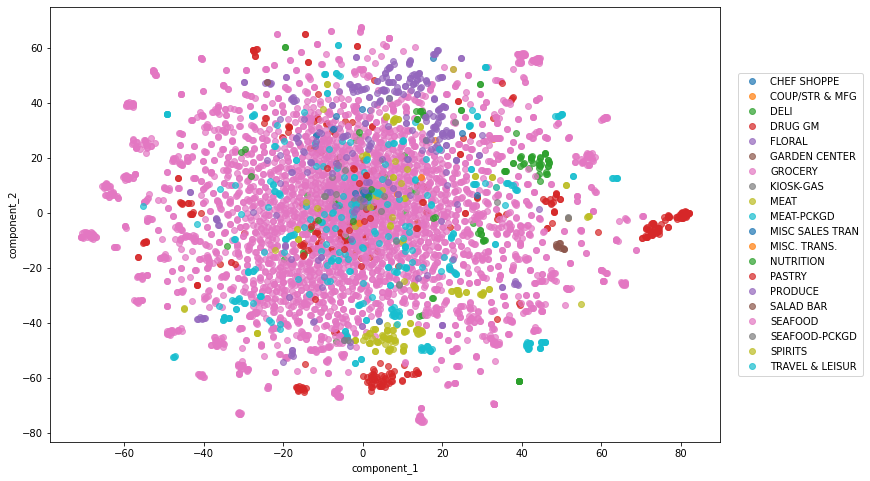

Wall time: 42 s


In [28]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

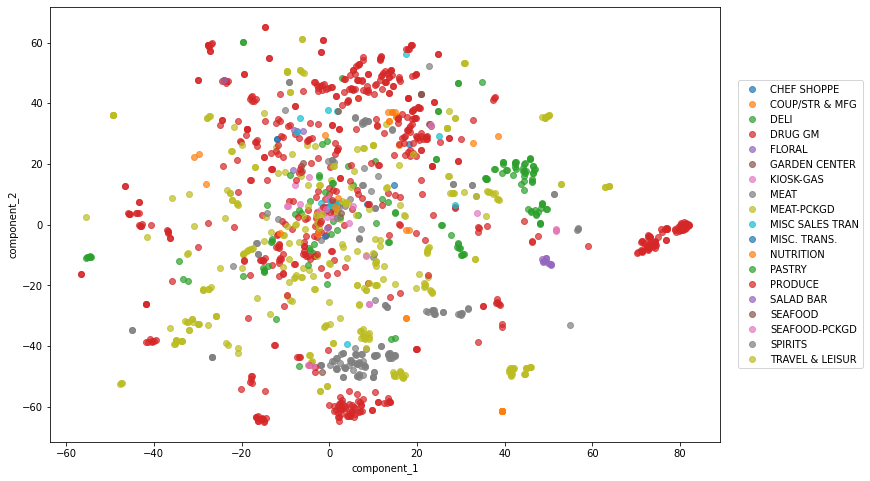

In [29]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Нарисуем несколько конкретных категорий

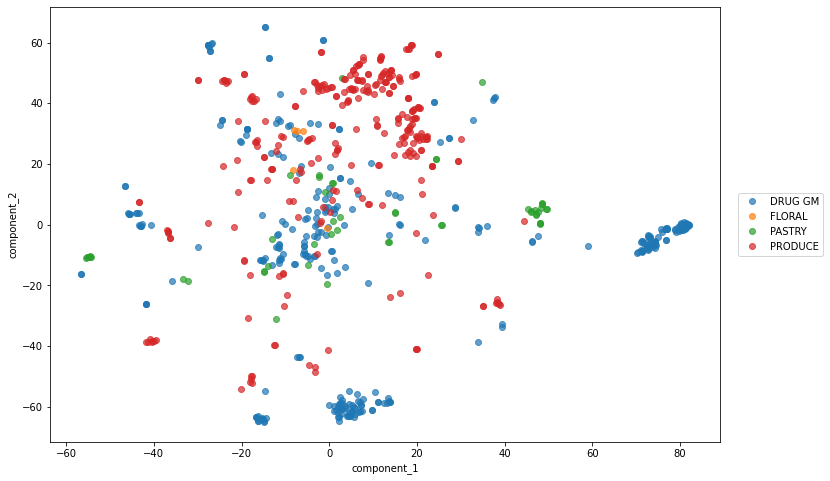

In [30]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

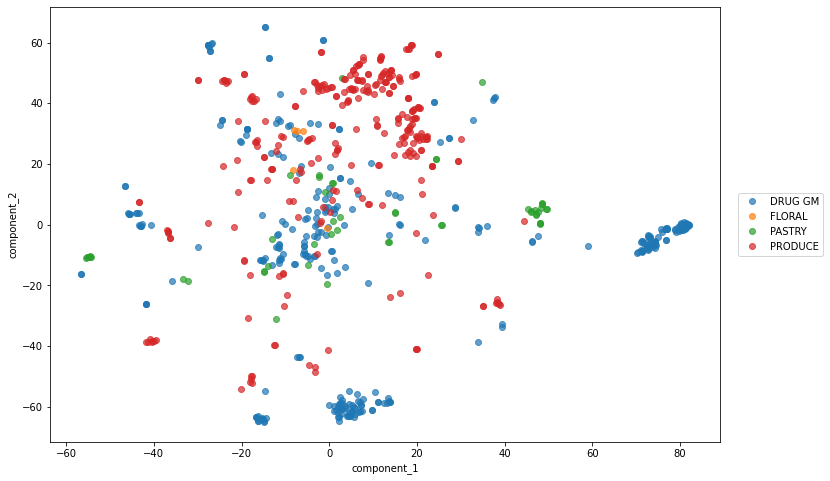

In [31]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

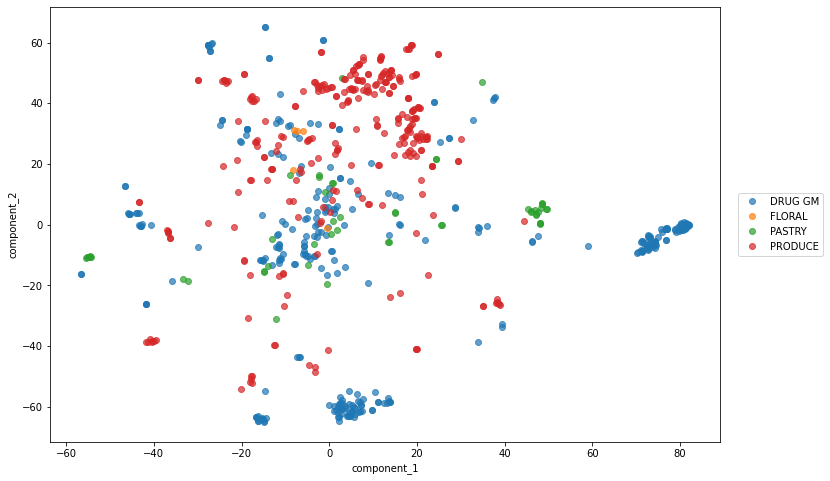

In [32]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

На самом деле, я бы сказал, что **результат средний**:
- Модель выучила похожесть только небольшой части товаров

In [33]:
item_emb_tsne.head(2)

,component_1,component_2,category
0,0.168396,5.589975,MISC SALES TRAN
1,-0.167610,8.511985,KIOSK-GAS


recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [34]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=csr_matrix(user_item_matrix).tocsr(),
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)


Wall time: 25.4 s


In [35]:
recommendations.shape

(2499, 5)

In [36]:
pd.DataFrame(recommendations)

,0,1,2,3,4
0,3031,192,3616,1927,2728
1,2148,2307,391,2927,1178
2,1516,3388,558,3029,1242
3,3408,1801,3587,110,4346
4,3408,2148,3133,2307,3587
...,...,...,...,...,...
2494,4287,1927,195,2434,76
2495,70,225,647,1516,3200
2496,4346,2148,1349,3587,2307
2497,300,2847,845,3704,578


In [37]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

In [38]:
item_1.shape

(100,)

In [39]:
item_1

array([ 0.0090871 , -0.00025201,  0.0027491 ,  0.00278641, -0.00058607,
        0.00166204,  0.00323256,  0.00317715,  0.00155751, -0.0009944 ,
        0.00113141,  0.00229139,  0.0066972 ,  0.00384235, -0.00067758,
        0.00249703, -0.00168469,  0.00014853,  0.00264631,  0.00626106,
        0.00560723,  0.00511902, -0.00072581,  0.00181714,  0.00099087,
        0.00615088,  0.00483196, -0.00130437, -0.00242939,  0.00460405,
        0.00525565,  0.00588702,  0.00734735,  0.00649182,  0.00599513,
        0.00359837,  0.0015024 ,  0.00854774,  0.00468656,  0.00634642,
        0.00105786,  0.00399622,  0.00075443,  0.00036813,  0.00363875,
        0.006638  , -0.00266019,  0.00667578,  0.0042733 , -0.00130048,
        0.00224356,  0.00936306,  0.00780391,  0.00416446, -0.00048416,
        0.00509395,  0.00401883, -0.00285024,  0.00433716,  0.00104375,
        0.00473589,  0.00245988,  0.00206956,  0.00406017,  0.00292899,
        0.00039464, -0.00164906,  0.00161318,  0.00129971,  0.00

*Посмотрите также / Похожие товары*

In [40]:
example_item_row_id = 3606

In [41]:
closest_items = [ id_to_itemid[row_id] for row_id, score in model.similar_items(example_item_row_id, N=5)]

In [42]:
item_features[item_features.item_id.isin(closest_items)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
8143,839040,942,GROCERY,National,CONDIMENTS/SAUCES,HOT MUSTARD/SPECIALTY MUSTAR,12 OZ
14959,899459,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT CHUNKS,1 LB
33695,1065669,69,GROCERY,Private,MILK BY-PRODUCTS,REFRIG DIPS,8 OZ
37579,1100265,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT SLICES,10 OZ
41087,1132131,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 6PK/4PK CAN CARB (,12 OZ


*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [43]:
model.similar_users(userid_to_id[10], N=5)

[(9, 0.9999999),
 (239, 0.9753628),
 (1380, 0.973831),
 (354, 0.9732828),
 (790, 0.97327083)]

### 2. TF-IDF взвешивание

In [44]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [45]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

NameError: name 'precision_at_k' is not defined

### 3. BM25 взвешивание

In [46]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\Users\tolpe\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [48]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))


Wall time: 47.5 s


In [50]:
result.to_csv('predictions_mf.csv', index=False)  # mf - matrix factorization

## 4. Важно искать оптимальные параметры

- regularization, iterations
- factors
- Вес (элемент в матрице user-item)

-----

# Production

Начиная с этого вебинара, мы будем строить *базовое решение* для системы рекомендаций топ-N товаров. В финальном проекте вам нужно будет его сущесвтенно улучшить.  
  
**Ситуация**: Вы работает data scientist в крупном продуктовом российском ритейлере. Ваш конкурент сделал рекомендательную систему, и его продажи выросли. Ваш менеджмент тоже хочет увеличить продажи   
**Задача со слов менеджера**: Сделайте рекомендательную систему топ-10 товаров для рассылки по e-mail

**Ожидание:**
- Отправляем e-mail с топ-10 товарами, отсортированными по вероятности

**Реальность:**
- Чего хочет менеджер от рекомендательной системы? (рост показателя X на Y% за Z недель)
- По-хорошему надо бы предварительно посчитать потенциальный эффект от рекоммендательной системы (Оценки эффектов у менеджера и у вас могут сильно не совпадать: как правило, вы знаете про данные больше)
- А у нас вообще есть e-mail-ы пользователей? Для скольки %? Не устарели ли они?
- Будем ли использовать СМС и push-уведомления в приложении? Может, будем печатать рекомендации на чеке после оплаты на кассе?
- Как будет выглядеть e-mail? (решаем задачу топ-10 рекомендаций или ранжирования? И топ-10 ли?)
- Какие товары должны быть в e-mail? Есть ли какие-то ограничения (только акции и т п)?
- Сколько денег мы готовы потратить на привлечение 1 юзера? CAC - Customer Aquisition Cost. Обычно CAC = расходы на коммуникацию + расходы на скидки
- Cколько мы хотим зарабатывать с одного привлеченного юзера?
---
- А точно нужно сортировать по вероятности?
- Какую метрику использовать?
- Сколько раз в неделю отпрпавляем рассылку?
- В какое время отправляем рассылку?
- Будем отправлять одному юзеру много раз наши рекоммендации. Как добиться того, чтобы они хоть немного отличались?
- Нужно ли, чтобы в одной рассылке были *разные* товары? Как определить, что товары *разные*? Как добиться того, чтобы они были разными?
- И многое другое:)

**В итоге договорились, что:**
- Хотим повысить выручку минимум на 6% за 4 месяца. Будем повышать за счет роста Retention минимум на  3% и среднего чека минимум на 3%
- Топ-5 товаров, а не топ-10 (В e-mail 10 выглядят не красиво, в push и на чек больше 5 не влезает)
- Рассылаем в e-mail (5% клиентов) и push-уведомлении (20% клиентов), печатаем на чеке (все оффлайн клиенты)
- **3 товара с акцией** (Как это учесть? А если на товар была акция 10%, а потом 50%, что будет стоять в user-item матрице?)
- **1 новый товар** (юзер никогда не покупал. Просто фильтруем аутпут ALS? А если у таких товаров очень маленькая вероятность покупки? Может, использовать другую логику/модель?) 
- **1 товар для роста среднего чека** (товары минимум дороже чем обычно покупает юзер. Как это измерить? На сколько дороже?)

Вопросов стало еще больше. Поэтому сначала делаем **MVP** (Minimum viable product) на e-mail. Показываем его менеджеру, измеряем метрики на юзерах. По фидбеку и метрикам делаем улучшения MVP и раскатываем его на push-уведомления и чеки

*Data Science проект* - итеративный процесс!

In [51]:
data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [52]:
data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))
data_train['price'].max()

<ipython-input-52-73e31537f690>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))


499.99

In [53]:
# < 1$
data_train['price'].quantile(0.20)

0.99

In [54]:
# > 100$
data_train['price'].quantile(0.99995)

82.01435450003483

In [55]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    max_week = data['week_no'].max()
    max_week_for_item = data_train.groupby('item_id')['week_no'].max().reset_index()
    
    new_items = max_week_for_item.loc[max_week_for_item['week_no'] > max_week - 52, 'item_id'].tolist()
     
    data = data[data['item_id'].isin(new_items)]    
    
    # Уберем не интересные для рекоммендаций категории (department)
    department_size = items_data.groupby('department')['item_id'].nunique().reset_index()
    department_size.columns = ['department', 'n_items']
    rare_departments = department_size[department_size['n_items'] < 150].department.tolist()
    items_in_rare_departments = items_data[items_data['department'].isin(rare_departments)].item_id.unique().tolist()
    data = data[~data['item_id'].isin(items_in_rare_departments)]
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    sales = data.groupby('item_id')[['sales_value', 'quantity']].sum().reset_index()
    sales.rename(columns={'sales_value': 'total_revenue', 'quantity': 'n_sold'}, inplace=True)
    sales['avg_price'] = np.where(sales['n_sold'] > 0, sales['total_revenue'] / sales['n_sold'], 0)
    ids_for_rec = sales[(sales['avg_price'] > 2) & (sales['avg_price'] < 50)].item_id.tolist()
    
    data = data[data['item_id'].isin(ids_for_rec)]
    
    # Уберем слишком дорогие товары
    sales = data.groupby('item_id')[['sales_value', 'quantity']].sum().reset_index()
    sales.rename(columns={'sales_value': 'total_revenue', 'quantity': 'n_sold'}, inplace=True)
    ids_for_rec = sales[(sales['avg_price'] > 2) & (sales['avg_price'] < 50)].item_id.tolist()
    
    # ...
    
def postfilter_items(user_id, recommednations):
    pass

Все эти функции отправим затем в *utils.py*

# ДЗ

1) Попытаться ответить на вопросы/выдвинуть гипотезы

2) Доделать прошлые домашния задания

3) Прочитать статьи BM25/MatrixFactorization

4) Поэкспериментировать с ALS (grid-search)

# Links

BM25

https://en.wikipedia.org/wiki/Okapi_BM25#:~:text=BM25%20is%20a%20bag%2Dof,slightly%20different%20components%20and%20parameters.


Matrix factorization (ALS, SVD)
https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/